In [1]:
using PyCall
using PyPlot
using FFTW
using LinearAlgebra
using JLD2
using YAML
# FFTW.set_num_threads(16)

@pyimport mpl_toolkits.axes_grid1 as axgrid
plt.style.use("dark_background")
# plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")

mpl = pyimport("matplotlib")
np = pyimport("numpy")

config = YAML.load_file("../config.yaml")

Dict{Any, Any} with 16 entries:
  "DM_particle_mass_Dark" => 0.00472716
  "run_name"              => "density_cube_snap_099_full_1024_all_species"
  "xmin"                  => 0.0
  "num_scales"            => 10
  "GAS_particle_mass_TNG" => 0.000743736
  "output_directory"      => "/global/cscratch1/sd/james12/NEXUS_analysis/"
  "nx"                    => 1024
  "N_GAS"                 => 15625000000
  "num_snaps"             => 1
  "snapfile_root"         => 99
  "algorithm"             => "NEXUS+"
  "input_directory"       => "/global/cscratch1/sd/james12/Illustris_TNG_Data/T…
  "simulation_type"       => "All"
  "DM_particle_mass_TNG"  => 0.00398343
  "N_DM"                  => 15625000000
  "xmax"                  => 205000.0

# Let's Load in the Maximum Signatures

We load in maximum signatures from the NEXUS algorithm run of the Dark Matter only simulation with resolution $1024^3$

In [2]:
config["output_directory"] *"Full_Species_1024_snap_099/"* "max_sigs_" * config["run_name"] * "_NEXUSPLUS" * "_full_signatures.jld2"

"/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/max_sigs_density_cube_snap_099_full_1024_all_species_NEXUSPLUS_full_signatures.jld2"

In [3]:
@load config["output_directory"] *"Full_Species_1024_snap_099/"* "max_sigs_" * config["run_name"] * "_NEXUSPLUS" * "_full_signatures.jld2" sigmax

1-element Vector{Symbol}:
 :sigmax

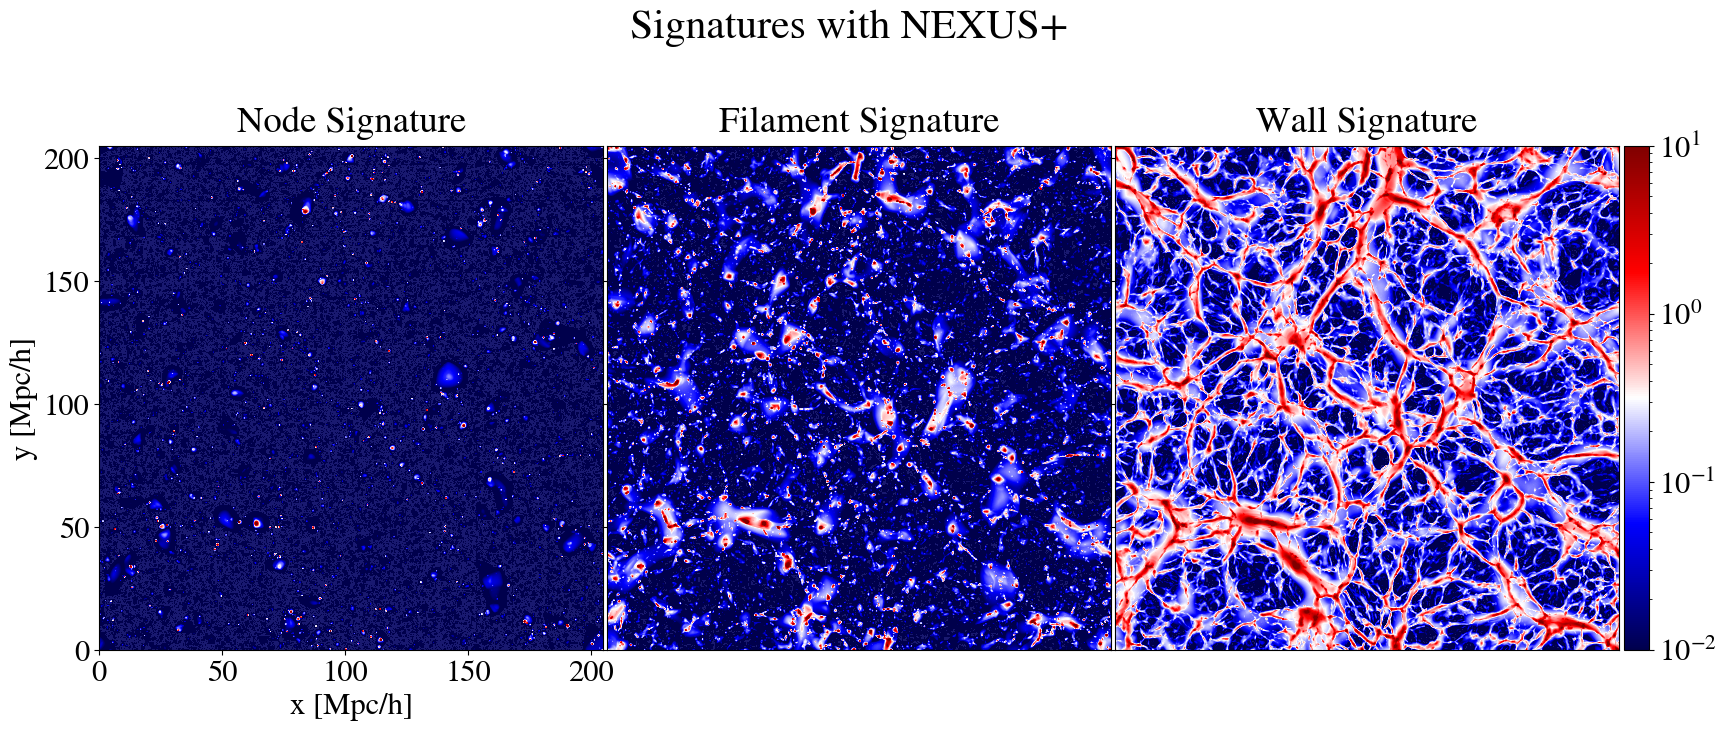

In [7]:

# plt.style.use("light_mode")
plt.style.use("default")
plt.rc("font", family="STIXGeneral")
plt.rc("font", size=22)
plt.rc("mathtext", fontset="stix")
plt.rc("axes", facecolor="midnightblue")

cmap_ = "seismic"
slice = 1020

f, axes = plt.subplots(1,3,sharey=true, gridspec_kw = Dict("wspace" => -0.05, "hspace" => 0), figsize=(20,8))

f.suptitle("Signatures with NEXUS+", fontsize=30)

axes[1].set_title("Node Signature", pad=10)
im1 = axes[1].imshow(sigmax[:,:,slice,1], origin="lower", cmap=cmap_, 
    extent=(0,config["xmax"]/1000,0,config["xmax"]/1000), norm=mpl.colors.LogNorm(vmin=0.01, vmax=10.0))

divider1 = axgrid.make_axes_locatable(axes[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cax1.set_axis_off()

axes[2].set_title("Filament Signature", pad=10)
im2 = axes[2].imshow(sigmax[:,:,slice,2], origin="lower", cmap=cmap_, 
    extent=(0,config["xmax"]/1000,0,config["xmax"]/1000), norm=mpl.colors.LogNorm(vmin=0.01, vmax=10.0))
divider2 = axgrid.make_axes_locatable(axes[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cax2.set_axis_off()

axes[3].set_title("Wall Signature", pad=10)
im3 = axes[3].imshow(sigmax[:,:,slice,3], origin="lower", cmap=cmap_, 
    extent=(0,config["xmax"]/1000,0,config["xmax"]/1000), norm=mpl.colors.LogNorm(vmin=0.01, vmax=10.0))
divider3 = axgrid.make_axes_locatable(axes[3])
cax3 = divider3.append_axes("right", size="5%", pad=0.05)

for ax in axes
    ax.set_aspect("equal")
    if ax == axes[1]
        ax.set_xlabel("x [Mpc/h]")
        ax.set_ylabel("y [Mpc/h]")
    else
        ax.set_xticks([])
        # ax.set_yticks([])
    end
end

plt.colorbar(im3, cax=cax3)
f.tight_layout()
# plt.savefig("NEXUSPLUS_Signatures_hydro.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

# Let's Determine Structure Types using Tagging

In [50]:
#reduce size of sigmax for example
sigmax = sigmax[1:512, 1:512, 1:512, :]

In [9]:
#load in data and reduce size for example
@load config["input_directory"] * config["run_name"] * ".jld2" den

1-element Vector{Symbol}:
 :den

### Import CosmoMMF

In [56]:
using CosmoMMF

In [ ]:
@time clusbool, filbool, wallbool, S_fil, dM2_fil, S_wall, dM2_wall = CosmoMMF.calc_structure_bools(mass_of_average_cell, 240.0, 
                                                                                                    sigmax_NEXUS, sigmax_NEXUSPLUS, den)

print("Generating Different Structure Boolean Filters")

## Plot Results!

In [3]:
@load "/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/heavy_halos/density_cube_snap_099_full_1024_all_species_cluster_bool_filter.jld2" clusbool
@load "/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/heavy_halos/density_cube_snap_099_full_1024_all_species_filament_bool_filter.jld2" filbool
@load "/global/cscratch1/sd/james12/NEXUS_analysis/Full_Species_1024_snap_099/heavy_halos/density_cube_snap_099_full_1024_all_species_wall_bool_filter.jld2" wallbool

clusbool_full = clusbool
filbool_full = filbool
wallbool_full = wallbool

@load "/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/heavy_halos/density_cube_snap_099_full_1024_dm_cluster_bool_filter.jld2" clusbool
@load "/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/heavy_halos/density_cube_snap_099_full_1024_dm_filament_bool_filter.jld2" filbool
@load "/global/cscratch1/sd/james12/NEXUS_analysis/DM_only_1024_snap_099/heavy_halos/density_cube_snap_099_full_1024_dm_wall_bool_filter.jld2" wallbool

clusbool_dm = clusbool
filbool_dm = filbool
wallbool_dm = wallbool

print("load succesful")

load succesful

In [5]:
@load config["input_directory"] * config["run_name"] * ".jld2" den

1-element Vector{Symbol}:
 :den

In [14]:
# a = 0:9  # don't use collect
# 0:9

test = ifelse.(clusbool_dm .== 0, nothing, clusbool_dm)

1024×1024×1024 Array{Union{Nothing, Bool}, 3}:
[:, :, 1] =
 nothing  nothing  nothing  nothing  …  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  …  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing  …  nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     nothing  nothing  nothing  nothing
 nothing  nothing  nothing  nothing     n

In [15]:
plt.imshow(test[:,:,1019], cmap="Reds", vmin=0, vmax=1.0)

LoadError: PyError ($(Expr(:escape, :(ccall(#= /global/homes/j/james12/.julia/packages/PyCall/3fwVL/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError('Image data of dtype object cannot be converted to float')
  File "/global/homes/j/james12/.conda/envs/baryon_env/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2730, in imshow
    **kwargs)
  File "/global/homes/j/james12/.conda/envs/baryon_env/lib/python3.7/site-packages/matplotlib/__init__.py", line 1447, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/global/homes/j/james12/.conda/envs/baryon_env/lib/python3.7/site-packages/matplotlib/axes/_axes.py", line 5523, in imshow
    im.set_data(X)
  File "/global/homes/j/james12/.conda/envs/baryon_env/lib/python3.7/site-packages/matplotlib/image.py", line 703, in set_data
    "float".format(self._A.dtype))


In [8]:
none = zeros((1024,1024, 1024))

1024×1024×1024 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.

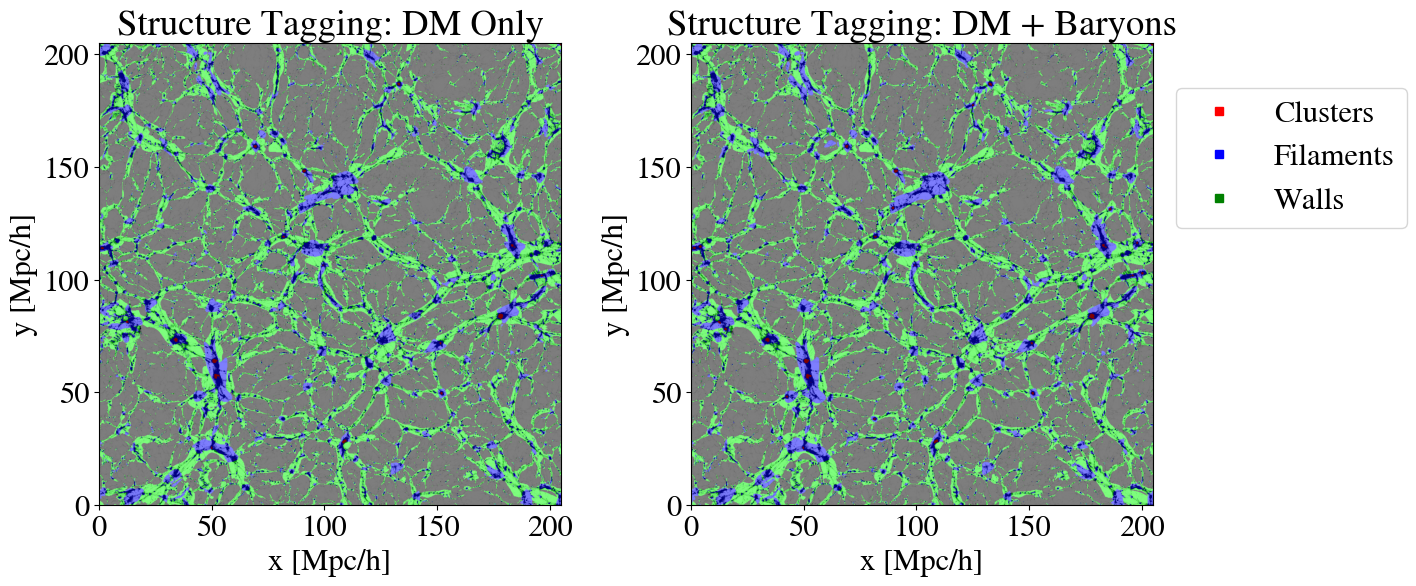

In [23]:

plt.style.use("default")
plt.style.use("light_mode")
# plt.rc("font", family="STIXGeneral")
# plt.rc("font", size=22)
# plt.rc("mathtext", fontset="stix")

fig, axes = subplots(1,2,figsize=(14,6))

slice = 1019
densq = -clamp.(den[:,:,slice], 0, 3)/3 .+ 1 # density plot
densq ./= 2


axes[1].set_title("Structure Tagging: DM Only")
axes[1].set_xlabel("x [Mpc/h]")
axes[1].set_ylabel("y [Mpc/h]")

axes[1].imshow(  cat( [
            transpose(clamp.(densq + (clusbool_dm[:,:,slice]) / 2, 0.0,1.0)), 
            transpose(clamp.(densq + wallbool_dm[:,:,slice] / 2, 0.0, 1.0)),
            transpose(clamp.(densq + filbool_dm[:,:,slice] / 2, 0.0, 1.0))]..., dims=3) ,
            origin="lower", extent=(0,config["xmax"]/1000,0,config["xmax"]/1000))






axes[2].set_title("Structure Tagging: DM + Baryons")
axes[2].set_xlabel("x [Mpc/h]")
axes[2].set_ylabel("y [Mpc/h]")

axes[2].imshow(  cat( [
            transpose(clamp.(densq + clusbool_full[:,:,slice] / 2, 0.0,1.0)), 
            transpose(clamp.(densq + wallbool_full[:,:,slice] / 2, 0.0, 1.0)),
            transpose(clamp.(densq + filbool_full[:,:,slice] / 2, 0.0, 1.0))]..., dims=3) ,
            origin="lower", extent=(0,config["xmax"]/1000,0,config["xmax"]/1000))

# axes[2].imshow(  cat( [
#             transpose(clamp.(clusbool_full[:,:,slice] / 2 .+ 0.25, 0.0,1.0)), 
#             transpose(clamp.(wallbool_full[:,:,slice] / 2 .+ 0.25, 0.0, 1.0)),
#             transpose(clamp.(filbool_full[:,:,slice] / 2 .+ 0.25, 0.0, 1.0))]..., dims=3) ,
#             origin="lower", extent=(0,config["xmax"]/1000,0,config["xmax"]/1000))







# ax.imshow(wallbool[:,:,slice], cmap="Greens")
# ax.imshow(filbool[:,:,slice], cmap="Blues")
# ax.imshow(clusbool[:,:,slice], cmap="Reds")

# plt.axvline()

axes[2].plot([],[],"rs", label="Clusters")
axes[2].plot([],[], "bs", label="Filaments")
axes[2].plot([],[], "gs", label="Walls")
axes[2].legend(loc=(1.05,0.6))
# plt.savefig("../../../../Images/NEXUSPLUS_Full_Species_all_components_darkmode.png", format="png", dpi=300, bbox_inches="tight")
plt.show()

In [17]:
clusbool[:10,:10,:10]

false

In [22]:
n_clus = sum(clusbool)

1467

In [23]:
n_fil = sum(filbool)

119951534

In [24]:
n_wall = sum(wallbool)

273308544

In [28]:
print(n_clus / 1024^3)
print("\n")
print(n_fil / 1024^3)
print("\n")
print(n_wall / 1024^3)

1.366250216960907e-6
0.11171357147395611
0.2545384168624878

In [34]:
findall(clusbool .== 1)

1467-element Vector{CartesianIndex{3}}:
 CartesianIndex(281, 246, 16)
 CartesianIndex(280, 247, 16)
 CartesianIndex(281, 247, 16)
 CartesianIndex(38, 1008, 16)
 CartesianIndex(37, 1009, 16)
 CartesianIndex(38, 1009, 16)
 CartesianIndex(280, 246, 17)
 CartesianIndex(281, 246, 17)
 CartesianIndex(280, 247, 17)
 CartesianIndex(281, 247, 17)
 CartesianIndex(282, 247, 17)
 CartesianIndex(280, 248, 17)
 CartesianIndex(281, 248, 17)
 ⋮
 CartesianIndex(890, 418, 1018)
 CartesianIndex(888, 419, 1018)
 CartesianIndex(889, 419, 1018)
 CartesianIndex(890, 419, 1018)
 CartesianIndex(889, 420, 1018)
 CartesianIndex(256, 319, 1019)
 CartesianIndex(257, 319, 1019)
 CartesianIndex(256, 320, 1019)
 CartesianIndex(257, 320, 1019)
 CartesianIndex(256, 319, 1020)
 CartesianIndex(257, 319, 1020)
 CartesianIndex(257, 320, 1020)